In [1]:
import random
import numpy as np
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import os
import cv2
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.metrics import structural_similarity as ss
import utils

### Principal functions

In [2]:
# load image from url
def load_target_image(image_url, color=True, size=None):
  image_path = "target_image"    
  urllib.request.urlretrieve(image_url,image_path)
  # Apply color
  if color:
      target = cv2.imread(image_path, cv2.IMREAD_COLOR)
      target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
  else:
      # Apply gray scale
      target = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  if size:
      # Only resizes image if it is needed!
      target = cv2.resize(src=target, dsize=size, interpolation=cv2.INTER_AREA)
  return target

In [3]:
# Helps to show image
def show_image(img_arr):    
  plt.figure(figsize=(6, 6))
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.show()

In [4]:
# Show results
def show_results(history, img_arr, org):
  plt.figure(figsize=(10,10))
  plt.tight_layout()

  plt.subplot(221)
  plt.axis("off")
  plt.imshow(img_arr/255)
  plt.title('best of generation')

  plt.subplot(222)
  plt.axis("off")
  plt.imshow(org/255)
  plt.title('target image')

  plt.subplot(212)
  lh = len(history)
  plt.xlim([lh-50, lh])
  plt.plot(history)
  plt.title('min fitness by generation') 
  plt.show()

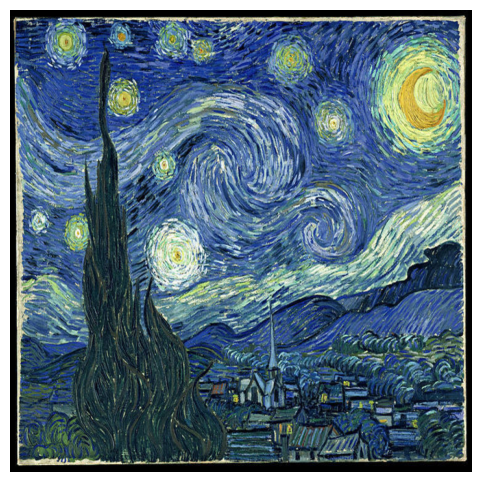

(1000, 1000, 3)


In [5]:
report_every_gen = 10
number_generations = 10000
polygons = 1000
size = 1000
target_image = "Art"


POLYGONS = polygons
SIZE = (size, size)

target_urls = utils.target_urls

target_image_url = target_urls[target_image]
target = load_target_image(target_image_url, size=SIZE)
show_image(target)
print(target.shape)

In [6]:
GENE_LENGTH = 10
NUM_GENES = POLYGONS * GENE_LENGTH

# Create individual
individual = np.random.uniform(0,1,NUM_GENES)
print(individual)

[0.12354704 0.73055133 0.02180068 ... 0.2442794  0.4721774  0.57082767]


In [7]:
def extract_genes(genes, length): 
    for i in range(0, len(genes), length): 
        yield genes[i:i + length]

In [8]:
def render_individual(individual):
  if isinstance(individual,list):
    individual = np.array(individual)
  canvas = np.zeros(SIZE+(3,))
  radius_avg = (SIZE[0] + SIZE[1]) / 2 / 6
  genes = extract_genes(individual, GENE_LENGTH)
  for gene in genes:
    try:
      overlay = canvas.copy()
      x1 = int(gene[0] * SIZE[0])
      x2 = int(gene[2] * SIZE[0])
      x3 = int(gene[4] * SIZE[0])
      y1 = int(gene[1] * SIZE[1])
      y2 = int(gene[3] * SIZE[1])
      y3 = int(gene[5] * SIZE[1])
      color = (gene[6:-1] * 255).astype(int).tolist() 
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]], np.int32)  
      pts = pts.reshape((-1, 1, 2))
      pts = np.array([[x1,y1],[x2,y2],[x3,y3]])

      cv2.fillPoly(overlay, [pts], color)
      alpha = gene[-1]
      canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)  
    except:
      pass
  return canvas

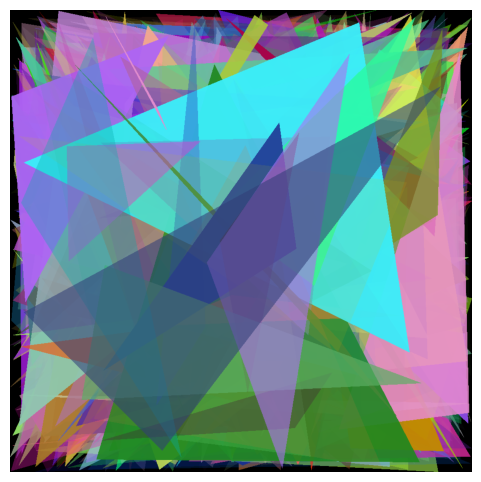

In [9]:
# Show individual
render = render_individual(individual)
show_image(render)

### Metrics

In [10]:
def fitness_mse(render):
  """Calculates Mean Square Error Fitness for a render"""
  error = (np.square(render - target)).mean(axis=None)
  return error

In [11]:
def fitness_ss(render):
  """Calculated Structural Similiarity Fitness"""
  index = ss(render, target, multichannel=True)
  return 1-index

In [12]:
print(fitness_mse(render))

6335.467360388326


In [13]:
# Apply Hyperparameters
IND_SIZE = NUM_GENES
MIN_VALUE = -1
MAX_VALUE = 1
MIN_STRATEGY = 0.5
MAX_STRATEGY = 5

CXPB = .6
MUTPB = .3

### Setting up creator

In [14]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", list, typecode="d")